In [ ]:
!pip -q install -U transformers datasets accelerate evaluate torchaudio librosa soundfile umap-learn scikit-learn pandas matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE = "/content/drive/MyDrive/tess_emotion_assignment"
DATA_DIR = f"{BASE}/data"
OUT_DIR  = f"{BASE}/outputs"
CKPT_DIR = f"{BASE}/checkpoints"

import os
for d in [DATA_DIR, OUT_DIR, CKPT_DIR]:
    os.makedirs(d, exist_ok=True)

print("BASE:", BASE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE: /content/drive/MyDrive/tess_emotion_assignment


In [ ]:
import os, shutil

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.copy("/content/kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

In [ ]:
KAGGLE_DATASET = "ejlok1/toronto-emotional-speech-set-tess"  # change if needed

!kaggle datasets download -d {KAGGLE_DATASET} -p {DATA_DIR} --unzip
print("Downloaded in:", DATA_DIR)

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 99% 424M/428M [00:03<00:00, 98.8MB/s]
100% 428M/428M [00:03<00:00, 123MB/s] 
Downloaded in: /content/drive/MyDrive/tess_emotion_assignment/data


In [ ]:
import glob, re, pathlib
import pandas as pd

wav_files = glob.glob(f"{DATA_DIR}/**/*.wav", recursive=True)
print("WAV count:", len(wav_files))
assert len(wav_files) > 0, "No .wav found. Check DATA_DIR."

WAV count: 5600


In [ ]:
def infer_emotion_from_path(p: str):
    low = p.lower()
    # TESS emotions usually include these:
    if "pleasant_surprise" in low or re.search(r"[_-]ps[_-]", low):
        return "pleasant_surprise"
    for e in ["angry","disgust","fear","happy","neutral","sad","surprise"]:
        if re.search(rf"[/_ -]{e}([/_ -]|$)", low) or f"_{e}." in low:
            return e
    # try folder name
    folder = pathlib.Path(p).parent.name.lower()
    if "pleasant" in folder and "surprise" in folder:
        return "pleasant_surprise"
    return None

In [ ]:
def infer_transcript_from_filename(p: str):
    # Example: OAF_back_angry.wav -> "back"
    name = pathlib.Path(p).stem.lower()
    name = re.sub(r"^(oaf|yaf)_", "", name)
    name = re.sub(r"_(angry|disgust|fear|happy|neutral|sad|surprise|pleasant_surprise|ps)$", "", name)
    return name.replace("_", " ").strip() or "unknown"

rows = []
for p in wav_files:
    emo = infer_emotion_from_path(p)
    if emo is None:
        continue
    rows.append({"audio_path": p, "text": infer_transcript_from_filename(p), "label": emo})

df = pd.DataFrame(rows)
print(df["label"].value_counts())
df.head()

label
fear                 800
pleasant_surprise    800
sad                  800
angry                800
disgust              800
happy                800
neutral              800
Name: count, dtype: int64


,audio_path,text,label
0,/content/drive/MyDrive/tess_emotion_assignment...,back,fear
1,/content/drive/MyDrive/tess_emotion_assignment...,bar,fear
2,/content/drive/MyDrive/tess_emotion_assignment...,base,fear
3,/content/drive/MyDrive/tess_emotion_assignment...,bath,fear
4,/content/drive/MyDrive/tess_emotion_assignment...,bean,fear


In [ ]:
from sklearn.model_selection import train_test_split

labels = sorted(df["label"].unique().tolist())
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
df["label_id"] = df["label"].map(label2id)

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["label_id"])
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label_id"])

print("train/val/test:", len(train_df), len(val_df), len(test_df))
print("labels:", labels)

train/val/test: 3920 840 840
labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprise', 'sad']


In [ ]:
!pip -q uninstall -y torchvision

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

TEXT_MODEL = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)

class TextDS(Dataset):
    def __init__(self, df):
        self.texts = df["text"].tolist()
        self.labels = df["label_id"].tolist()
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        enc = tokenizer(self.texts[i], truncation=True, max_length=128, return_tensors="pt")
        item = {k:v.squeeze(0) for k,v in enc.items()}
        item["labels"] = torch.tensor(self.labels[i], dtype=torch.long)
        return item

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [ ]:
def collate_text(batch):
    labels_ = torch.stack([b["labels"] for b in batch])
    inputs = [{k:v for k,v in b.items() if k!="labels"} for b in batch]
    padded = tokenizer.pad(inputs, return_tensors="pt")
    padded["labels"] = labels_
    return padded

metric_acc = evaluate.load("accuracy")
metric_f1  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, y = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=y)["accuracy"],
        "macro_f1": metric_f1.compute(predictions=preds, references=y, average="macro")["f1"]
    }

text_model = AutoModelForSequenceClassification.from_pretrained(
    TEXT_MODEL,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
mask_predictions.classifier.weight      | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
lm_predictions.lm_head.bias             | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
pooler.dense.bias                       | MISSING    | 
classifier.bias                         | MISSING    | 
classifier.weight                       | MISSING    | 
pooler.dense.weight      

In [ ]:
import torch
print(torch.cuda.get_device_name(0))
print("bf16 supported:", torch.cuda.is_bf16_supported())

Tesla T4
bf16 supported: True


In [ ]:
args = TrainingArguments(
    output_dir=f"{CKPT_DIR}/text_deberta",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,   # safe on Colab free
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=False,
    bf16=True,
    report_to="none",
    logging_steps=50
)

trainer = Trainer(
    model=text_model,
    args=args,
    train_dataset=TextDS(train_df),
    eval_dataset=TextDS(val_df),
    data_collator=collate_text,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.000000,nan,0.142857,0.035714
2,0.000000,nan,0.142857,0.035714
3,0.000000,nan,0.142857,0.035714


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['deberta.embeddings.LayerNorm.weight', 'deberta.embeddings.LayerNorm.bias', 'deberta.encoder.layer.0.attention.output.LayerNorm.weight', 'deberta.encoder.layer.0.attention.output.LayerNorm.bias', 'deberta.encoder.layer.0.output.LayerNorm.weight', 'deberta.encoder.layer.0.output.LayerNorm.bias', 'deberta.encoder.layer.1.attention.output.LayerNorm.weight', 'deberta.encoder.layer.1.attention.output.LayerNorm.bias', 'deberta.encoder.layer.1.output.LayerNorm.weight', 'deberta.encoder.layer.1.output.LayerNorm.bias', 'deberta.encoder.layer.2.attention.output.LayerNorm.weight', 'deberta.encoder.layer.2.attention.output.LayerNorm.bias', 'deberta.encoder.layer.2.output.LayerNorm.weight', 'deberta.encoder.layer.2.output.LayerNorm.bias', 'deberta.encoder.layer.3.attention.output.LayerNorm.weight', 'deberta.encoder.layer.3.attention.output.LayerNorm.bias', 'deberta.encoder.layer.3.output.LayerNorm.weight', 'deberta.encoder.layer.3.output.Laye

TrainOutput(global_step=1470, training_loss=0.06235758982548097, metrics={'train_runtime': 214.3868, 'train_samples_per_second': 54.854, 'train_steps_per_second': 6.857, 'total_flos': 6282171110784.0, 'train_loss': 0.06235758982548097, 'epoch': 3.0})

In [ ]:
from transformers import AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"
text_encoder = AutoModel.from_pretrained(TEXT_MODEL).to(device).eval()

@torch.no_grad()
def extract_text_embeddings(df_, batch_size=64):
    texts = df_["text"].tolist()
    y = df_["label_id"].to_numpy()

    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
        out = text_encoder(**enc)
        cls = out.last_hidden_state[:, 0, :]  # CLS
        embs.append(cls.cpu().numpy())
    return np.vstack(embs), y

text_train_emb, y_train = extract_text_embeddings(train_df.reset_index(drop=True))
text_val_emb,   y_val   = extract_text_embeddings(val_df.reset_index(drop=True))
text_test_emb,  y_test  = extract_text_embeddings(test_df.reset_index(drop=True))

np.save(f"{OUT_DIR}/text_train.npy", text_train_emb)
np.save(f"{OUT_DIR}/text_val.npy",   text_val_emb)
np.save(f"{OUT_DIR}/text_test.npy",  text_test_emb)

np.save(f"{OUT_DIR}/y_train.npy", y_train)
np.save(f"{OUT_DIR}/y_val.npy",   y_val)
np.save(f"{OUT_DIR}/y_test.npy",  y_test)

print("Saved text embeddings to:", OUT_DIR)
print("Shapes:", text_train_emb.shape, text_val_emb.shape, text_test_emb.shape)

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
mask_predictions.classifier.weight      | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Saved text embeddings to: /content/drive/MyDrive/tess_emotion_assignment/outputs
Shapes: (3920, 768) (840, 768) (840, 768)


In [ ]:
import torchaudio
from torch.utils.data import Dataset
from transformers import AutoProcessor, AutoModelForAudioClassification

SPEECH_MODEL = "facebook/wav2vec2-base"
processor = AutoProcessor.from_pretrained(SPEECH_MODEL)

TARGET_SR = 16000

def load_audio(path):
    wav, sr = torchaudio.load(path)
    wav = wav.mean(dim=0)  # mono
    if sr != TARGET_SR:
        wav = torchaudio.functional.resample(wav, sr, TARGET_SR)
    return wav.numpy()

class SpeechDS(Dataset):
    def __init__(self, df):
        self.paths = df["audio_path"].tolist()
        self.labels = df["label_id"].tolist()
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {"audio": load_audio(self.paths[i]), "labels": self.labels[i]}

def collate_speech(batch):
    audios = [b["audio"] for b in batch]
    labels_ = torch.tensor([b["labels"] for b in batch], dtype=torch.long)
    inputs = processor(audios, sampling_rate=TARGET_SR, return_tensors="pt", padding=True)
    inputs["labels"] = labels_
    return inputs

speech_model = AutoModelForAudioClassification.from_pretrained(
    SPEECH_MODEL,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

Wav2Vec2ForSequenceClassification LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     | 
-----------------------------+------------+-
project_hid.weight           | UNEXPECTED | 
quantizer.weight_proj.bias   | UNEXPECTED | 
project_hid.bias             | UNEXPECTED | 
project_q.bias               | UNEXPECTED | 
quantizer.codevectors        | UNEXPECTED | 
quantizer.weight_proj.weight | UNEXPECTED | 
project_q.weight             | UNEXPECTED | 
classifier.bias              | MISSING    | 
projector.bias               | MISSING    | 
classifier.weight            | MISSING    | 
projector.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
import librosa
import numpy as np

TARGET_SR = 16000

def load_audio(path: str) -> np.ndarray:
    # librosa loads as float32 mono by default when mono=True
    x, _ = librosa.load(path, sr=TARGET_SR, mono=True)
    return x

In [ ]:
!pip -q install -U librosa soundfile

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset

import librosa
from transformers import AutoProcessor, AutoModelForAudioClassification, TrainingArguments, Trainer

SPEECH_MODEL = "facebook/wav2vec2-base"
TARGET_SR = 16000

processor = AutoProcessor.from_pretrained(SPEECH_MODEL)

# (optional) cache to speed up repeated epochs
_AUDIO_CACHE = {}

def load_audio(path: str) -> np.ndarray:
    if path in _AUDIO_CACHE:
        return _AUDIO_CACHE[path]
    x, _ = librosa.load(path, sr=TARGET_SR, mono=True)
    _AUDIO_CACHE[path] = x
    return x

In [ ]:
class SpeechDS(Dataset):
    def __init__(self, df):
        self.paths = df["audio_path"].tolist()
        self.labels = df["label_id"].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return {
            "audio": load_audio(self.paths[i]),
            "labels": int(self.labels[i])
        }

def collate_speech(batch):
    # batch is list[dict]
    if "audio" not in batch[0]:
        raise KeyError(f"Expected key 'audio' in batch items. Got keys: {list(batch[0].keys())}")

    audios = [b["audio"] for b in batch]
    labels_ = torch.tensor([b["labels"] for b in batch], dtype=torch.long)

    inputs = processor(
        audios,
        sampling_rate=TARGET_SR,
        return_tensors="pt",
        padding=True
    )
    inputs["labels"] = labels_
    return inputs

# quick sanity check (run once)
tmp = SpeechDS(train_df)[0]
print("Sample keys:", tmp.keys(), "audio_len:", len(tmp["audio"]), "label:", tmp["labels"])

Sample keys: dict_keys(['audio', 'labels']) audio_len: 31630 label: 3


In [ ]:
speech_model = AutoModelForAudioClassification.from_pretrained(
    SPEECH_MODEL,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

FREEZE_ENCODER = True
if FREEZE_ENCODER:
    for p in speech_model.wav2vec2.parameters():
        p.requires_grad = False
    print("✅ Froze wav2vec2 encoder. Training classification head only.")
else:
    print("⚠️ Full fine-tuning enabled (more GPU memory needed).")

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

Wav2Vec2ForSequenceClassification LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     | 
-----------------------------+------------+-
project_hid.weight           | UNEXPECTED | 
quantizer.weight_proj.bias   | UNEXPECTED | 
project_hid.bias             | UNEXPECTED | 
project_q.bias               | UNEXPECTED | 
quantizer.codevectors        | UNEXPECTED | 
quantizer.weight_proj.weight | UNEXPECTED | 
project_q.weight             | UNEXPECTED | 
classifier.bias              | MISSING    | 
projector.bias               | MISSING    | 
classifier.weight            | MISSING    | 
projector.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


✅ Froze wav2vec2 encoder. Training classification head only.


In [ ]:
speech_args = TrainingArguments(
    output_dir=f"{CKPT_DIR}/speech_wav2vec2",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,

    learning_rate=1e-3 if FREEZE_ENCODER else 1e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    num_train_epochs=8 if FREEZE_ENCODER else 5,
    weight_decay=0.01,

    fp16=False,  # keep off since you hit fp16 scaler errors earlier

    remove_unused_columns=False,  # ✅ THIS FIXES YOUR KEYERROR
    report_to="none",
    logging_steps=50
)

In [ ]:
speech_trainer = Trainer(
    model=speech_model,
    args=speech_args,
    train_dataset=SpeechDS(train_df),
    eval_dataset=SpeechDS(val_df),
    data_collator=collate_speech,
    compute_metrics=compute_metrics
)

speech_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.224683,0.591916,0.795238,0.794973
2,0.134926,1.456797,0.629762,0.623594
3,0.151609,0.374312,0.892857,0.890307
4,0.107012,0.564478,0.865476,0.847362
5,0.035895,0.234704,0.928571,0.927657
6,0.071831,0.212715,0.929762,0.927865
7,0.102925,0.257086,0.915476,0.913684
8,0.059759,0.166428,0.942857,0.941557


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=15680, training_loss=0.175241340163677, metrics={'train_runtime': 2017.6566, 'train_samples_per_second': 15.543, 'train_steps_per_second': 7.771, 'total_flos': 6.3772080536853e+17, 'train_loss': 0.175241340163677, 'epoch': 8.0})

In [ ]:
test_dataset = SpeechDS(test_df)

test_results = speech_trainer.predict(test_dataset)

logits = test_results.predictions
y_true = test_results.label_ids
y_pred = np.argmax(logits, axis=1)

from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("Test Macro F1:", f1_score(y_true, y_pred, average="macro"))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

Test Accuracy: 0.9404761904761905
Test Macro F1: 0.9384540616132927

Classification Report:

                   precision    recall  f1-score   support

            angry       0.97      1.00      0.98       120
          disgust       0.92      0.97      0.94       120
             fear       1.00      1.00      1.00       120
            happy       0.99      0.71      0.83       120
          neutral       0.98      0.97      0.97       120
pleasant_surprise       0.84      0.94      0.89       120
              sad       0.92      1.00      0.96       120

         accuracy                           0.94       840
        macro avg       0.94      0.94      0.94       840
     weighted avg       0.94      0.94      0.94       840



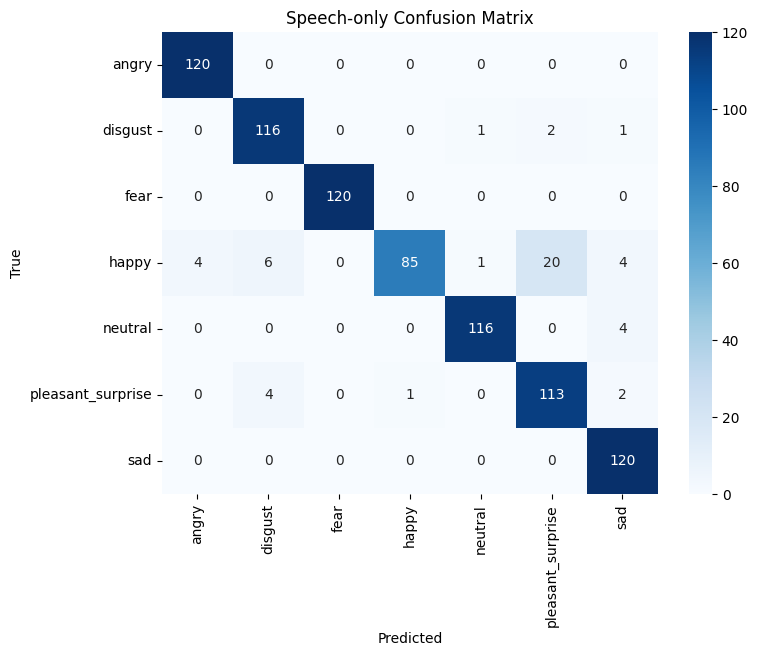

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Speech-only Confusion Matrix")
plt.show()

In [ ]:
from transformers import AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"
speech_encoder = AutoModel.from_pretrained(SPEECH_MODEL).to(device).eval()

@torch.no_grad()
def extract_audio_embeddings(df_, batch_size=8):
    paths = df_["audio_path"].tolist()
    y = df_["label_id"].to_numpy()

    embs = []
    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i+batch_size]
        audios = [load_audio(p) for p in batch_paths]
        inp = processor(audios, sampling_rate=TARGET_SR, return_tensors="pt", padding=True).to(device)
        out = speech_encoder(**inp)
        pooled = out.last_hidden_state.mean(dim=1)  # (B, H)
        embs.append(pooled.cpu().numpy())

    return np.vstack(embs), y

audio_train_emb, y_train2 = extract_audio_embeddings(train_df.reset_index(drop=True))
audio_val_emb,   y_val2   = extract_audio_embeddings(val_df.reset_index(drop=True))
audio_test_emb,  y_test2  = extract_audio_embeddings(test_df.reset_index(drop=True))

import os
OUT_DIR = f"{BASE}/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

np.save(f"{OUT_DIR}/audio_train.npy", audio_train_emb)
np.save(f"{OUT_DIR}/audio_val.npy",   audio_val_emb)
np.save(f"{OUT_DIR}/audio_test.npy",  audio_test_emb)

print("Saved:", OUT_DIR)
print("Shapes:", audio_train_emb.shape, audio_val_emb.shape, audio_test_emb.shape)

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

Wav2Vec2Model LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     |  | 
-----------------------------+------------+--+-
project_hid.weight           | UNEXPECTED |  | 
quantizer.weight_proj.bias   | UNEXPECTED |  | 
project_hid.bias             | UNEXPECTED |  | 
project_q.bias               | UNEXPECTED |  | 
quantizer.codevectors        | UNEXPECTED |  | 
quantizer.weight_proj.weight | UNEXPECTED |  | 
project_q.weight             | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Saved: /content/drive/MyDrive/tess_emotion_assignment/outputs
Shapes: (3920, 768) (840, 768) (840, 768)


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

test_text_ds = TextDS(test_df)
pred_out = trainer.predict(test_text_ds)

logits = pred_out.predictions
y_true = pred_out.label_ids
y_pred = np.argmax(logits, axis=-1)

print("Text Test Accuracy:", accuracy_score(y_true, y_pred))
print("Text Test Macro F1:", f1_score(y_true, y_pred, average="macro"))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

Text Test Accuracy: 0.14285714285714285
Text Test Macro F1: 0.03571428571428571

Classification Report:

                   precision    recall  f1-score   support

            angry     0.1429    1.0000    0.2500       120
          disgust     0.0000    0.0000    0.0000       120
             fear     0.0000    0.0000    0.0000       120
            happy     0.0000    0.0000    0.0000       120
          neutral     0.0000    0.0000    0.0000       120
pleasant_surprise     0.0000    0.0000    0.0000       120
              sad     0.0000    0.0000    0.0000       120

         accuracy                         0.1429       840
        macro avg     0.0204    0.1429    0.0357       840
     weighted avg     0.0204    0.1429    0.0357       840



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


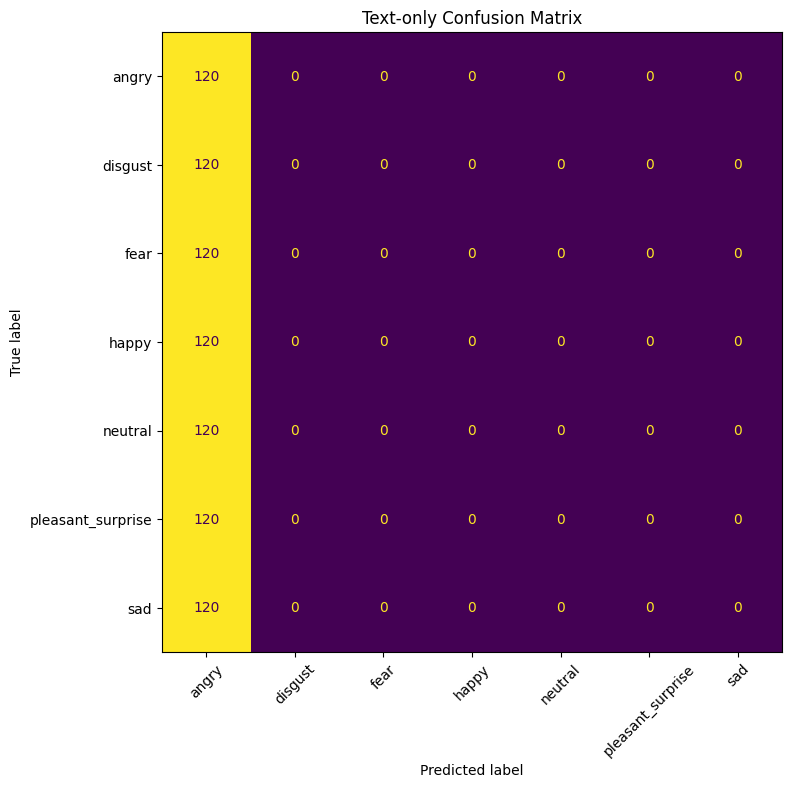

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=45, values_format="d", colorbar=False)
ax.set_title("Text-only Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
import os

# Auto-detect saved folder
possible_dirs = [
    f"{BASE}/outputs",
    "/content/outputs",
    "/content/drive/MyDrive/tess_emotion_assignment/outputs"
]

OUT_DIR = None
for d in possible_dirs:
    if os.path.exists(os.path.join(d, "text_train.npy")):
        OUT_DIR = d
        break

assert OUT_DIR is not None, "Could not find saved embeddings folder."

print("Using OUT_DIR:", OUT_DIR)

Using OUT_DIR: /content/drive/MyDrive/tess_emotion_assignment/outputs


In [ ]:
import os
import numpy as np

OUT_DIR = "/content/drive/MyDrive/tess_emotion_assignment/outputs"

def load_npy(name):
    path = os.path.join(OUT_DIR, name)
    assert os.path.exists(path), f"Missing file: {path}"
    return np.load(path)

# Load text embeddings
text_train = load_npy("text_train.npy")
text_val   = load_npy("text_val.npy")
text_test  = load_npy("text_test.npy")

# Load audio embeddings
audio_train = load_npy("audio_train.npy")
audio_val   = load_npy("audio_val.npy")
audio_test  = load_npy("audio_test.npy")

# Load labels
y_train = load_npy("y_train.npy")
y_val   = load_npy("y_val.npy")
y_test  = load_npy("y_test.npy")

print("Loaded shapes:")
print("Text:", text_train.shape, text_val.shape, text_test.shape)
print("Audio:", audio_train.shape, audio_val.shape, audio_test.shape)
print("Labels:", y_train.shape, y_val.shape, y_test.shape)

# Build fused features
X_train = np.concatenate([audio_train, text_train], axis=1)
X_val   = np.concatenate([audio_val,   text_val], axis=1)
X_test  = np.concatenate([audio_test,  text_test], axis=1)

print("Fused shape:", X_train.shape)

Loaded shapes:
Text: (3920, 768) (840, 768) (840, 768)
Audio: (3920, 768) (840, 768) (840, 768)
Labels: (3920,) (840,) (840,)
Fused shape: (3920, 1536)


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

Xtr = torch.tensor(X_train, dtype=torch.float32)
Ytr = torch.tensor(y_train, dtype=torch.long)

Xva = torch.tensor(X_val, dtype=torch.float32)
Yva = torch.tensor(y_val, dtype=torch.long)

Xte = torch.tensor(X_test, dtype=torch.float32)
Yte = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(Xtr, Ytr), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva, Yva), batch_size=128, shuffle=False)

class FusionMLP(nn.Module):
    def __init__(self, in_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes)
        )
    def forward(self, x):
        return self.net(x)

fusion_model = FusionMLP(Xtr.shape[1], len(labels)).to(device)
opt = torch.optim.AdamW(fusion_model.parameters(), lr=1e-3, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss()

best_f1 = -1.0
best_state = None

for epoch in range(1, 21):
    fusion_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = fusion_model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()

    # validate
    fusion_model.eval()
    all_pred, all_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            pred = fusion_model(xb).argmax(dim=-1).cpu().numpy()
            all_pred.append(pred)
            all_true.append(yb.numpy())

    all_pred = np.concatenate(all_pred)
    all_true = np.concatenate(all_true)
    val_acc = accuracy_score(all_true, all_pred)
    val_f1  = f1_score(all_true, all_pred, average="macro")

    print(f"Epoch {epoch:02d} | val_acc={val_acc:.4f} val_macro_f1={val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_state = {k: v.detach().cpu().clone() for k, v in fusion_model.state_dict().items()}

fusion_model.load_state_dict(best_state)
print("Best val macro_f1:", best_f1)

device: cuda
Epoch 01 | val_acc=0.5345 val_macro_f1=0.5007
Epoch 02 | val_acc=0.6726 val_macro_f1=0.6626
Epoch 03 | val_acc=0.8107 val_macro_f1=0.8110
Epoch 04 | val_acc=0.8667 val_macro_f1=0.8644
Epoch 05 | val_acc=0.8917 val_macro_f1=0.8917
Epoch 06 | val_acc=0.9012 val_macro_f1=0.9005
Epoch 07 | val_acc=0.8869 val_macro_f1=0.8863
Epoch 08 | val_acc=0.8619 val_macro_f1=0.8568
Epoch 09 | val_acc=0.8833 val_macro_f1=0.8770
Epoch 10 | val_acc=0.9381 val_macro_f1=0.9377
Epoch 11 | val_acc=0.9417 val_macro_f1=0.9412
Epoch 12 | val_acc=0.9321 val_macro_f1=0.9315
Epoch 13 | val_acc=0.9548 val_macro_f1=0.9543
Epoch 14 | val_acc=0.9440 val_macro_f1=0.9437
Epoch 15 | val_acc=0.9595 val_macro_f1=0.9594
Epoch 16 | val_acc=0.9488 val_macro_f1=0.9486
Epoch 17 | val_acc=0.9512 val_macro_f1=0.9508
Epoch 18 | val_acc=0.9655 val_macro_f1=0.9655
Epoch 19 | val_acc=0.9476 val_macro_f1=0.9468
Epoch 20 | val_acc=0.9583 val_macro_f1=0.9582
Best val macro_f1: 0.9655071001410755


FUSION Test Accuracy: 0.9630952380952381
FUSION Test Macro F1: 0.9631920983269712

Classification Report:

                   precision    recall  f1-score   support

            angry     0.9916    0.9833    0.9874       120
          disgust     0.9833    0.9833    0.9833       120
             fear     1.0000    0.9917    0.9958       120
            happy     0.8976    0.9500    0.9231       120
          neutral     0.9915    0.9667    0.9789       120
pleasant_surprise     0.9060    0.8833    0.8945       120
              sad     0.9752    0.9833    0.9793       120

         accuracy                         0.9631       840
        macro avg     0.9636    0.9631    0.9632       840
     weighted avg     0.9636    0.9631    0.9632       840



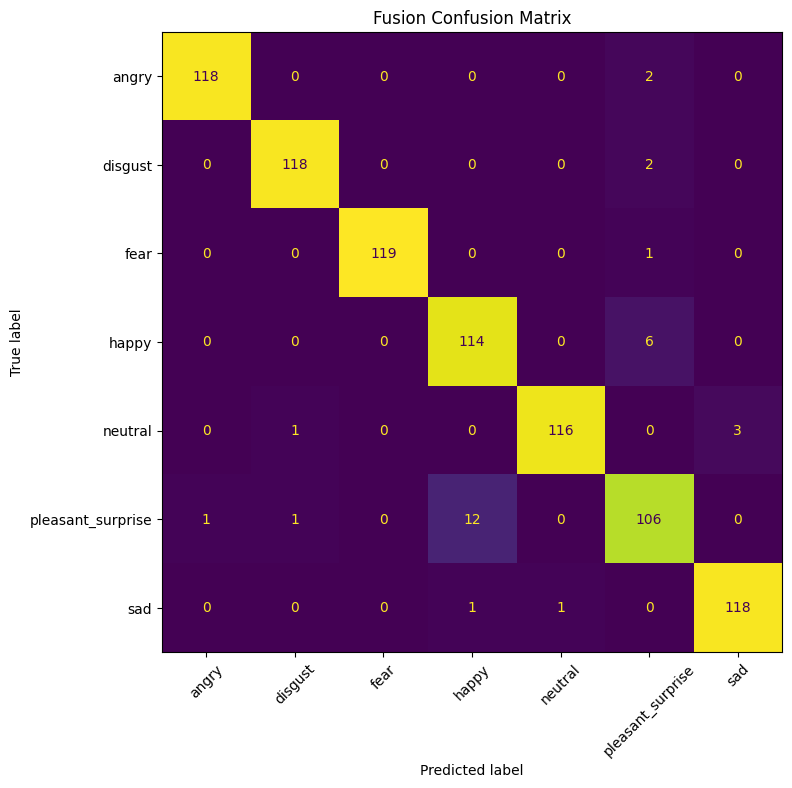

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

fusion_model.eval()
with torch.no_grad():
    y_pred = fusion_model(Xte.to(device)).argmax(dim=-1).cpu().numpy()

test_acc = accuracy_score(y_test, y_pred)
test_f1  = f1_score(y_test, y_pred, average="macro")

print("FUSION Test Accuracy:", test_acc)
print("FUSION Test Macro F1:", test_f1)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=list(range(len(labels))))
disp = ConfusionMatrixDisplay(cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, xticks_rotation=45, values_format="d", colorbar=False)
ax.set_title("Fusion Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
import os

RESULTS_DIR = "/content/drive/MyDrive/tess_emotion_assignment/Results"
PLOTS_DIR = f"{RESULTS_DIR}/plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

print("Using PLOTS_DIR:", PLOTS_DIR)

Using PLOTS_DIR: /content/drive/MyDrive/tess_emotion_assignment/Results/plots


In [ ]:
!pip -q install umap-learn
import umap

def umap_plot(emb, y, title, outpath):
    reducer = umap.UMAP(n_neighbors=20, min_dist=0.15, metric="cosine", random_state=42)
    z = reducer.fit_transform(emb)

    plt.figure(figsize=(8,6))
    for i, lab in enumerate(labels):
        idx = (y == i)
        plt.scatter(z[idx,0], z[idx,1], s=10, alpha=0.7, label=lab)

    plt.legend(markerscale=2, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close()

umap_plot(audio_test, y_test, "UMAP: Speech Embeddings", f"{PLOTS_DIR}/umap_speech.png")
umap_plot(text_test,  y_test, "UMAP: Text Embeddings",   f"{PLOTS_DIR}/umap_text.png")
umap_plot(X_test,     y_test, "UMAP: Fusion Embeddings", f"{PLOTS_DIR}/umap_fusion.png")

print("Saved UMAP plots in:", PLOTS_DIR)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved UMAP plots in: /content/drive/MyDrive/tess_emotion_assignment/Results/plots


In [ ]:
import shutil

zip_path = "/content/Results_part3.zip"
shutil.make_archive("/content/Results_part3", "zip", RESULTS_DIR)
print("Created:", zip_path)

from google.colab import files
files.download(zip_path)

Created: /content/Results_part3.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>